In [1]:
import time
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import kstest, norm
from scipy import stats as sps
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Latex
from sklearn import preprocessing as sklpp
from sklearn import decomposition as skldecomp
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import KFold

# Dataset 3- SMS Spam Collection Dataset


## 3.a

This is the third and final dataset explored for this project. It is a text-based dataset that contains 5574 samples of text messages labeled as Spam or Ham, with Ham meaning not spam. 

For this dataset, Gaussian Naive Bayes, Linear Discriminant Analysis (LDA), and Quadratic Discriminant Analysis (QDA) will be the methods used. 

In [2]:
## Importing the Dataset ##

sms_spam = pd.read_csv('Dataset3/SMSSpamCollection.csv')

print(sms_spam.shape)
sms_spam

(5574, 2)


,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5569,spam,This is the 2nd time we have tried 2 contact u...
5570,ham,Will Ã¼ b going to esplanade fr home?
5571,ham,"Pity, * was in mood for that. So...any other s..."
5572,ham,The guy did some bitching but I acted like i'd...


In [3]:
sms_spam.groupby('Label').count()

,SMS
Label,
ham,4827
spam,747


Visualization of the amount of SMS that are labeled as Ham, and Spam

Albeit loading the Dataset onto a Pandas DataFrame, there are still extra steps that need to be taken in order to work with this dataset. Currently, the dataset tells us nothing, and any classification would be meaningless. In order to give this data some meaning, it will have to undergo some pre-processing.

## 3.b Pre Processing

As mentioned previosly, this dataset cannot function in its current form, so I need to use what is known as a Bag of Words model in order to properly use it. <br>

When working with text classification, it is important to remove any unwanted characters, such as punctuation or numbers as they will not be necessary. Additionally, all words must be converted to lowercase, just so that there are no word repetitions (i.e **Guy** and **guy** should be counted as the same, and not different). <br>

In [4]:
# make all lowercase
sms_spam['SMS'] = sms_spam['SMS'].str.lower()

# remove all punctuations
sms_spam['SMS'] = sms_spam['SMS'].str.replace('[^a-zA-Z]', ' ')

In [5]:
sms_spam

,Label,SMS
0,ham,go until jurong point crazy available only ...
1,ham,ok lar joking wif u oni
2,spam,free entry in a wkly comp to win fa cup fina...
3,ham,u dun say so early hor u c already then say
4,ham,nah i don t think he goes to usf he lives aro...
...,...,...
5569,spam,this is the nd time we have tried contact u...
5570,ham,will b going to esplanade fr home
5571,ham,pity was in mood for that so any other s...
5572,ham,the guy did some bitching but i acted like i d...


In [7]:
vectorizer = CountVectorizer(max_features=1000) # max_features=1000 -> use the 1000 most common words

notorious_big = vectorizer.fit_transform(sms_spam['SMS'].values) # variabled named after 1992 rapper Notorious B.I.G

words_list = vectorizer.get_feature_names()
X = notorious_big.toarray() # simple variable name for the dataset independent variables 
print(X)
y = sms_spam.iloc[:, 0] # dependent variable

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## 3.c Feature Extraction

For feature extraction, Principal Component Alalysis will be used in order to reduce the dimensionality of the data. PCA wil be used in a way that will retain most of the information  by transforming a larger dataset into a smaller dataset. It can make analyzing the data faster and easier. 

Text(0.5, 0.91, '90% capture')

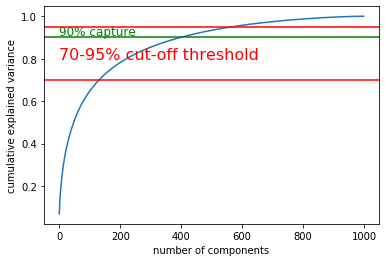

In [11]:
pca = PCA().fit(X.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.axhline(y=0.70, color='r', linestyle='-')
plt.axhline(y=0.9, color='g', linestyle='-') # capture 90% of the energy 
plt.text(0.5, 0.8, '70-95% cut-off threshold', color = 'red', fontsize=16)
plt.text(0.5, 0.91, '90% capture', color = 'green', fontsize=12)

By using a method similar to Dataset1, we can see what would be a good number of components for the PCA dataset. If we want to capture 90% of the energy, the dataset will reduce from 1000 features to around 400 features. 

In [12]:
sms_pca = skldecomp.PCA(n_components=0.9, svd_solver='full')
sms_features = sms_pca.fit_transform(X)
print("PCA on SMS Dataset: ",sms_features.shape)

PCA on SMS Dataset:  (5574, 399)


## 3.d Processing the Datasets

Now that the data is ready to be utilized by the Machine Learning Methods that will be used. <br>

As mentioned previously, the following methods will be used with this dataset: 
- Gaussian Naive Bayes Classifier (GNB)
- Linear Discriminant Analysis (LDA)
- Quadratric Discriminant Analysis (QDA)

A question that comes to mind is, why these specific methods? The reason these methods were chose was because they all follow a Gaussian distribution. Due to the high dimensionality of our data, it is impossible to plot and show that the distributions are Normal. By using a test known as the Kolmogorov Smirnov test<sup>[6]</sup>, we can get a more definitive answer as to wether or not our Dataset has normal distribution <br>

By using the KS Test, if the datatset follows a normal distribution, then the value of *ks_statistic* will be about 0. Then, we use the *p_value* to decide difference is large enough to reject if the dataset has a normal distribution. 
- if the *p_value* > 0.05, we assume normal distribution
- if the *p_value* < 0.05, we do not assume normal distribution

In [46]:
X2 = X # copy of the dataset so that the KS Test does not mess up the original dataset 
X2 = norm.rvs(size=1000)
ks_statistic, p_value = kstest(X2, 'norm')
print(ks_statistic, p_value)

0.019886896059341796 0.816249424789363


Since the *ks_statistic* value is almost 0, and the *p_value* is much greater than 0.05, we can safely assume that our data follows a normal distribution, and thus allows us to make use of GNB, LDA and QDA

### 3.d.i Gaussian Naive Bayes (GNB) Classifier

As its name implies, the GBN Classifier utilizes a Gaussian Naive Bayes likelihood for classification. The Gaussian Naive Bayes is assumed Gaussian with:

<center> P(x<sub>i</sub>|y) = $\frac{1}{\sqrt(2\pi\sigma^2}exp(-\frac{(x_i-\mu_y)^2}{2\sigma_2^2})$  </center>

with the parameters $\sigma_y$ and $\mu_y$ are estimated from the Maximum Likelihood. <br>

K-Fold Cross Validation will be ran with K = 5 for checking performance. 

In [26]:
gnb_run_time = [] # list of time for each iteration
gnb_conf_matrix = [] # list of the confusion matrices for each iteration
gnb_accuracy = [] # list of the accuracy for each iteration

gnb_kfold = KFold(n_splits=5,shuffle=True) # initialize the kfold cross validation
for train_index, test_index in gnb_kfold.split(X):
    X_train, X_test = X[train_index], X[test_index] # Training Data, Test Data
    y_train, y_test = y[train_index], y[test_index] # Training Data, Test Data
    t0_gnb = time.time()
    heavens_door = GaussianNB() # named after the Bob Dylan song-  Knockin' on Heaven's Door
    heavens_door.fit(X_train,y_train) # fit to the GNB Classifier
    Y_pred = heavens_door.predict(X_test) # predict class
    gnb_time = time.time()-t0_gnb
    gnb_run_time.append(gnb_time)
    gnb_cm = confusion_matrix(y_test, Y_pred) # confusion matrix
    gnb_conf_matrix.append(gnb_cm)
    gnb_cr = classification_report(y_test, Y_pred) # classification report - shows main classification metrics
    accuracy_gnb = accuracy_score(y_test, Y_pred) # accuracy
    gnb_accuracy.append(accuracy_gnb)

average_gnb_accuracy = sum(gnb_accuracy)/5
print("Average Accurary:",average_gnb_accuracy)
print("Classification Report\n",gnb_cr)
average_gnb_time = sum(gnb_run_time)/5
print("Average run time after doing 5-fold Cross Validation:", average_gnb_time)

Average Accurary: 0.7865105344937244
Classification Report
               precision    recall  f1-score   support

         ham       0.98      0.78      0.87       970
        spam       0.38      0.92      0.54       144

    accuracy                           0.80      1114
   macro avg       0.68      0.85      0.70      1114
weighted avg       0.91      0.80      0.83      1114

Average run time after doing 5-fold Cross Validation: 0.09887175559997559


### 3.d.ii Linear Discriminant Analysis (LDA) Classifier

The next machine learning method that will be used in this dataset is Classification with Linear Discriminant Analysis. It is a Maximum A Posteriori (MAP) Classifier that assumes the likelihood functions to follow a Gaussian distribution, with different means but equal covariance matrices for each class. <br>

We estimate the unbiased estimation of the covariance matrix as:

<center>     $C $ = $\frac{1}{n-L}$ $\sum_{l = 1}^{L}$$\sum_{i:y_i=L}^{} (x_i - \mu_L)(x_i - \mu_L)^T$       </center>

And then, our Multivariate LDA Equation for classification is: 

<center>     $\delta_L(x) $ = argmax $[x^T C^{-1} \mu_L -\frac{1}{2}  \mu_L^T C^{-1} \mu_L + ln(\pi_L)$       </center>


In [49]:
lda_run_time = [] # list of time for each iteration
lda_conf_matrix = [] # list of the confusion matrices for each iteration
lda_accuracy = [] # list of the accuracy for each iteration

lda_kfold = KFold(n_splits=5,shuffle=True) # initialize the kfold cross validation
for lda_train_index, lda_test_index in lda_kfold.split(X):
    lda_X_train, lda_X_test = X[train_index], X[test_index] # Training Data, Test Data
    lda_y_train, lda_y_test = y[train_index], y[test_index] # Training Data, Test Data
    t0_lda = time.time()
    earth_wind_fire = LinearDiscriminantAnalysis() # named after the 1969 band Earth, Wind & Fire 
    earth_wind_fire.fit(lda_X_train,lda_y_train) # fit to the LDA Classifier
    lda_Y_pred = earth_wind_fire.predict(lda_X_test) # predict class
    lda_time = time.time()-t0_lda
    lda_run_time.append(lda_time)
    lda_cm = confusion_matrix(lda_y_test, lda_Y_pred) # confusion matrix
    lda_conf_matrix.append(lda_cm)
    lda_cr = classification_report(lda_y_test, lda_Y_pred) # classification report - shows main classification metrics
    accuracy_lda = accuracy_score(lda_y_test, lda_Y_pred) # accuracy
    lda_accuracy.append(accuracy_lda)

average_lda_accuracy = sum(lda_accuracy)/5
print("Average Accurary:",average_lda_accuracy)
print("Classification Report\n",lda_cr)
average_lda_time = sum(lda_run_time)/5
print("Average run time after doing 5-fold Cross Validation:", average_lda_time)

Average Accurary: 0.9793536804308797
Classification Report
               precision    recall  f1-score   support

         ham       0.98      0.99      0.99       970
        spam       0.95      0.89      0.92       144

    accuracy                           0.98      1114
   macro avg       0.97      0.94      0.95      1114
weighted avg       0.98      0.98      0.98      1114

Average run time after doing 5-fold Cross Validation: 1.7674550533294677


### 3.d.iii Quadratic Discriminant Analysis (LDA) Classifier

Finally, the last method employed in this dataset is Classification with Quadratic Discriminant Analysis. It is similar to LDA except that both the mean and covariance matrix are different for any class. <br>

We estimate the unbiased estimation of the covariance matrix as:

<center>    $C_L $ = $\frac{1}{n_L-L}$ $\sum_{l = 1}^{L}$$\sum_{i:y_i=L}^{} (x_i - \mu_L)(x_i - \mu_L)^T$      </center>

And then, our Multivariate QDA Equation for classification is: 

<center>    $\delta_L(x) $ = argmax $[-\frac{1}{2}x^{T}C_L^{-1}x + x^{T}C_L^{-1}\mu_L -\frac{1}{2} \mu_L^T C_L^{-1} \mu_L - \frac{1}{2}(det(C_L)) + ln(\pi_L)]$      </center>

In [54]:
qda_run_time = [] # list of time for each iteration
qda_conf_matrix = [] # list of the confusion matrices for each iteration
qda_accuracy = [] # list of the accuracy for each iteration

qda_kfold = KFold(n_splits=5,shuffle=True) # initialize the kfold cross validation
for train_index, test_index in qda_kfold.split(X):
    qda_X_train, qda_X_test = X[train_index], X[test_index] # Training Data, Test Data
    qda_y_train, qda_y_test = y[train_index], y[test_index] # Training Data, Test Data
    t0_qda = time.time()
    yellow_submarine = QuadraticDiscriminantAnalysis() # named after The Beatles Song- Yellow Submarine 
    yellow_submarine.fit(qda_X_train,qda_y_train) # fit to the QDA Classifier
    qda_Y_pred = yellow_submarine.predict(qda_X_test) # predict class
    qda_time = time.time()-t0_qda
    qda_run_time.append(qda_time)
    qda_cm = confusion_matrix(qda_y_test, qda_Y_pred) # confusion matrix
    qda_conf_matrix.append(qda_cm)
    qda_cr = classification_report(qda_y_test, qda_Y_pred) # classification report - shows main classification metrics
    accuracy_qda = accuracy_score(qda_y_test, qda_Y_pred) # accuracy
    qda_accuracy.append(accuracy_qda)

average_qda_accuracy = sum(qda_accuracy)/5
print("Average Accurary:",average_qda_accuracy)
print("Classification Report\n",qda_cr)
average_qda_time = sum(qda_run_time)/5
print("Average run time after doing 5-fold Cross Validation:", average_qda_time)

c:\users\robert\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\robert\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\robert\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\robert\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\robert\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Average Accurary: 0.9630420816191801
Classification Report
               precision    recall  f1-score   support

         ham       0.96      0.99      0.98       956
        spam       0.94      0.77      0.84       158

    accuracy                           0.96      1114
   macro avg       0.95      0.88      0.91      1114
weighted avg       0.96      0.96      0.96      1114

Average run time after doing 5-fold Cross Validation: 1.7138815879821778


## 3.e Comparative Analysis

In [55]:
print("GNB run time after doing 5-fold Cross Validation (seconds):", average_gnb_time)
print("LDA run time after doing 5-fold Cross Validation (seconds):", average_lda_time)
print("QDA run time after doing 5-fold Cross Validation (seconds):", average_qda_time)

GNB run time after doing 5-fold Cross Validation (seconds): 0.09887175559997559
LDA run time after doing 5-fold Cross Validation (seconds): 1.7674550533294677
QDA run time after doing 5-fold Cross Validation (seconds): 1.7138815879821778


When it comes to the speed of various methods that were used, Gaussian Naive Bayes is by far the fastest of the three, followed by QDA and finally LDA surprisingly. When it comes to the K-Fold Cross validation, shuffling was used, which shuffles the data before before splitting into the folds. 

In [56]:
print("Average GNB Accurary:",average_gnb_accuracy)
print("Average LDA Accurary:",average_lda_accuracy)
print("Average QDA Accurary:",average_qda_accuracy)

Average GNB Accurary: 0.7865105344937244
Average LDA Accurary: 0.9793536804308797
Average QDA Accurary: 0.9630420816191801


Next, the three methods have varying accuracy, with LDA having the highest accuracy out of the three methods. GNB has the lowest accuracy with only 78.6%, much lower than QDA and LDA. Both of these classifiers are almost classifying correctly, as seen with LDA having, rounding up, a 98% accuracy and QDA having a 96.3% accuracy. <br>

Now, time to take a look at the confusion matrices<sup>[7]</sup>, which are the sum of the covariances per each iteration of the kfold cross validation.<sup>[5]</sup>

[[3693 1134]
 [  56  691]]


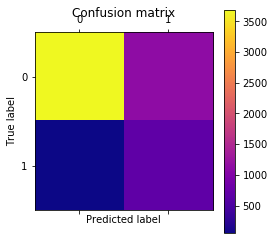

In [52]:
overall_conf_gnb = sum(gnb_conf_matrix) # overall GNB confusion matrix 

print(overall_conf_gnb)

plt.matshow(overall_conf_gnb, cmap= 'plasma') # using the plasma cmap color for easier visualization between the shades of color
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

[[4815   35]
 [  80  640]]


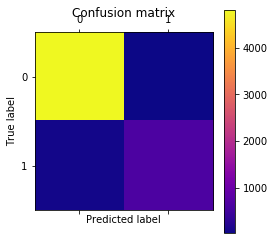

In [53]:
overall_conf_lda = sum(lda_conf_matrix) # overall confusion matrix for LDA

print(overall_conf_lda)
plt.matshow(overall_conf_lda, cmap= 'plasma')
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

[[4774   53]
 [ 153  594]]


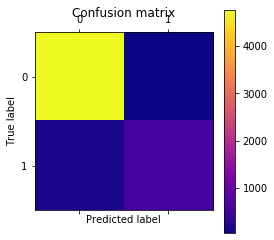

In [57]:
overall_conf_qda = sum(qda_conf_matrix) # get the overall confusion matrix

print(overall_conf_qda)
plt.matshow(overall_conf_qda, cmap= 'plasma')
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Finally, we can see that the confusion matrices for each of the methods are almost the same. The rates for each of the methods are the following:
- True Positive Rate:
    - GNB: 0.76
    - LDA: 0.99
    - QDA: 0.98
- True Negative Rate:
    - GNB: 0.92
    - LDA: 0.88
    - QDA: 0.79
- False Positive Rate:
    - GNB: 0.23
    - LDA: 0.05
    - QDA: 0.08
- False Negative Rate:
    - GNB: 0.01
    - LDA: 0.01
    - QDA: 0.03

When it comes to selecting one of the three methods, it has to be the one with the best results. For this dataset, LDA gives the best results. Albeit being the slowest with a time of 1.76s compared so the other two, it has an outstanding 98% accuracy, the highest of the three and the various rates are also extremly good. <br>

For these reasons, LDA is the method that should be selected. 

## 3.f Ethical Issues

This dataset is just a simple method of classifying text, and the way it is classified is either as spam or not spam. Depending on how similar models are used, it can both benefit, or cause detriments, to society. <br>

Some ways that it can benefit the individual is, similar to the task in this dataset, filter out spam from normal messages, or e-mail. With a good enough collection of data, it is possible to classify as in this dataset, which can improve the lives of individuals who have to constantly check their e-mails or messages to make sure that what they are receicing is legitemate. <br>

Unfortunately, there is an ugly darkside to using these sorts of methods. It can show existing prejudices that were not in sight. There was such a case at Amazon, in which a recruiting tool dismissed female candidates, which was trained on historical hiring decisions, due to the use of gendered words<sup>[9]</sup>. That doesn't stop there either, as even ignoring gendered words, there were implicit words that still correlated with either men and women, and still made discriminatory decisions<sup>[9]</sup>. Due to these issues, it is clear that while Machine Learning tasks can be used in a variety of ways to help out in many areas of our lives, but the training for the task has to be done carefully. <br>

For ML Engineers, it is essential that when an algorithm is trained, it should be done so that it can be both fair and without discrimination, even unintentionally. In a perfect world, this would be the case, but alas, this is far from a perfect world and thus data could potentually be riddled with biases that are not normally observed. As was in the case of Amazon, the best course of action in such a case, would be to fix the causes of the biases, and keep tuning our methods so that they can be as fair as possible. 

## 3.g References used in this Dataset

1)<br>
Horbonos (Midvel Corp), Pavel. “How to Build and Apply Naive Bayes Classification for Spam Filtering.” Medium, Towards Data Science, 31 Jan. 2020, https://towardsdatascience.com/how-to-build-and-apply-naive-bayes-classification-for-spam-filtering-2b8d3308501.

2)<br>
Rajendran, Charles. “Text Classification Using the Bag Of Words Approach with NLTK and Scikit Learn.” Medium, The Startup, 7 May 2020, https://medium.com/swlh/text-classification-using-the-bag-of-words-approach-with-nltk-and-scikit-learn-9a731e5c4e2f\.

3)<br>
Brownlee, Jason. “How to Encode Text Data for Machine Learning with Scikit-Learn.” Machine Learning Mastery, 27 June 2020, https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/.

4)<br>
Jaadi, Zakaria. “A Step-by-Step Explanation of Principal Component Analysis.” Built In, Sept. 2019, https://builtin.com/data-science/step-step-explanation-principal-component-analysis.

5)<br>
Jain, Ritika. (2020). Re: How can I create a single confusion matrix after K fold cross validation ?. Retrieved from: https://www.researchgate.net/post/How_can_I_create_a_single_confusion_matrix_after_K_fold_cross_validation/5f89d22d29ccb76f7031a5d3/citation/download. 

6)<br>
Korstanje, Joos. “6 Ways to Test for a Normal Distribution - Which One to Use?” Medium, Towards Data Science, 17 Feb. 2020, https://towardsdatascience.com/6-ways-to-test-for-a-normal-distribution-which-one-to-use-9dcf47d8fa93.

7)<br>
hmghalyhmghaly 1, et al. “Sklearn Plot Confusion Matrix with Labels.” Stack Overflow, 1 Nov. 1962, https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels/48018785

8)<br>
“What Do We Do About the Biases in AI?” Harvard Business Review, 25 Oct. 2019, hbr.org/2019/10/what-do-we-do-about-the-biases-in-ai.

9)<br>
Hao, Karen. “This Is How AI Bias Really Happens-and Why It's so Hard to Fix.” MIT Technology Review, MIT Technology Review, 2 Apr. 2020, www.technologyreview.com/2019/02/04/137602/this-is-how-ai-bias-really-happensand-why-its-so-hard-to-fix/.